In [1]:
!pip install mlpack
!pip install conda
!conda install -c mlpack mlpack

     |████████████████████████████████| 93.0 MB 54 kB/s 
     |████████████████████████████████| 299 kB 8.5 MB/s 
     |████████████████████████████████| 66 kB 4.9 MB/s 
     |████████████████████████████████| 109 kB 61.6 MB/s 
     |████████████████████████████████| 546 kB 38.3 MB/s 
  Created wheel for conda: filename=conda-4.3.16-py3-none-any.whl size=336960 sha256=9e55f165e23c789829192ed9bb329f3b638fdc8bf2a2c3e8936290961dce3d2b
  Stored in directory: /root/.cache/pip/wheels/66/ec/2c/cce33d7a071720882d948fd3364d3ff5562bac9e5638768d41
  Created wheel for pycosat: filename=pycosat-0.6.3-cp37-cp37m-linux_x86_64.whl size=143866 sha256=0bc5529543f92c4847ec9146ff1ebfbb7634b8a674d0f9cbd618eedfa58bac6f
  Stored in directory: /root/.cache/pip/wheels/c8/29/0e/a226b7c5a4f24e246f25201c0b1fbf6fb8f19f9cce89b02c36
Successfully built conda pycosat
ERROR: The install method you used for conda--probably either `pip install conda`
or `easy_install conda`--is not compatible with using conda as an appli

In [151]:
from sklearn import datasets
from mlpack import emst
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import timeit

# ***Start of TopoPy***

*Finding the rigid motion (rotation plus translation) that minimizes the sum of squared distances to the expanded convex hull without penetrating it.*

In [250]:
def calculate_angle(point1, point2):
  x = point2[0] - point1[0]
  y = point2[1] - point1[1]
  angle = -np.arctan2(y, x)
  return angle

*Convex hull is used to perform the alignment by appropriately transforming both components.*

In [255]:
def align_hull(points, vertices, top):
  center = points[vertices[0]]
  rotated_points = np.zeros((0, 2))

  if top == True: # bottom edge of convex hull parallel to x-axis
    angle = calculate_angle(points[vertices[0]], points[vertices[1]])
  else: # top edge of convex hull parallel to x-axis
    angle = calculate_angle(points[vertices[0]], points[vertices[1]]) + np.pi

  for i in range(points.shape[0]):
    if i == vertices[0]: 
      rotated_points = np.vstack((rotated_points, center))
    else:
      x = points[i][0] - center[0]
      y = points[i][1] - center[1]

      x_prime = (x*np.cos(angle)) - (y*np.sin(angle)) + center[0]
      y_prime = (x*np.sin(angle)) + (y*np.cos(angle)) + center[1]

      xy_prime = np.array([x_prime, y_prime])
      rotated_points = np.vstack((rotated_points, xy_prime))

  rotated_points = rotated_points - center
  return rotated_points 

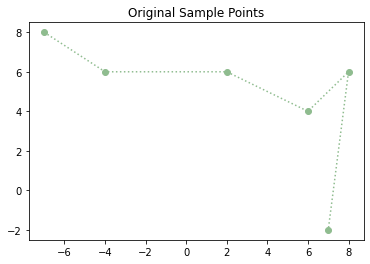

In [256]:
pts = np.array([(-7,8),(-4,6), (2,6), (6,4), (8,6), (7,-2)])
hull = ConvexHull(pts)
hull_pts = align_hull(pts, hull.vertices, True)
x = pts[:,0]
y = pts[:,1]
plt.title("Original Sample Points")
plt.plot(x, y, color = "darkseagreen", marker = "o", linestyle=':')


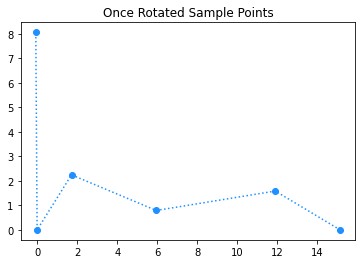

In [257]:
x = hull_pts[:,0]
y = hull_pts[:,1]
plt.title("Once Rotated Sample Points")
plt.plot(x, y, color='dodgerblue', marker = "o", linestyle=':')


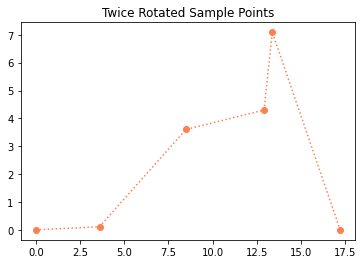

In [258]:
hull2 = ConvexHull(hull_pts)
hull_pts2 = align_hull(hull_pts, hull2.vertices, True)
x = hull_pts2[:,0]
y = hull_pts2[:,1]
plt.title("Twice Rotated Sample Points")
plt.plot(x, y, color='coral', marker = "o", linestyle=':')


# ***Loading Iris Dataset***

In [130]:
#Iris Dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df["target"] = iris.target
iris_df.drop_duplicates(inplace = True)
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


*   *The ordered set of topology changing edges is equivalent to the set of edges of the minimum spanning tree, in increasing order of weight.*
*   *The algorithm places the points onto a plane such that the MST edges are preserved.* 



# ***EMST***

In [129]:
# each row represents an edge in Iris dataset
# column 0 --> lesser index of the edge
# column 1 --> greater index of the edge
# column 2 --> distance between two points

def compute_EMST(): 
    Emst = emst(input = points, naive=False)
    out = Emst['output']
    vertices = out[:,0:2]
    edges = out[:,2]
    return vertices, edges 

In [133]:
#Euclidean Minimum Spanning Tree 
points = iris_df.drop('target', axis = 1).to_numpy()
target = iris_df['target'].to_numpy()
r2_points = None 
v, e = compute_EMST()

# ***Generalized MST Implementation***
##### Allows for various distance metric inputs

In [188]:
#referenced from https://peekaboo-vision.blogspot.com/2012/02/simplistic-minimum-spanning-tree-in.html
#Minimum Spanning Tree that allows for additional distance metrics
from scipy.spatial.distance import pdist, squareform

def minimum_spanning_tree(X, copy_X = True):
    #X --> edge weights of fully connected graph
    if copy_X:
        X = X.copy()

    if X.shape[0] != X.shape[1]:
        raise ValueError("X needs to be square matrix of edge weights")
    
    vertices = X.shape[0]
    spanning_edges = []
    
    #initialize with node 0                                                                                         
    visited_vertices = [0]                                                                                            
    num_visited = 1

    #excludes self connections
    diag_indices = np.arange(vertices)
    X[diag_indices, diag_indices] = np.inf
    
    while num_visited != vertices:

        new_edge = np.argmin(X[visited_vertices], axis=None)
        
        #new_edge, get correct indices                                                      
        new_edge = divmod(new_edge, vertices) #(quotient, remainder)
        new_edge = [visited_vertices[new_edge[0]], new_edge[1]]                                                       
        
        #adds edge to tree
        spanning_edges.append(new_edge)
        visited_vertices.append(new_edge[1])
       
        #remove all edges inside current tree
        X[visited_vertices, new_edge[1]] = np.inf
        X[new_edge[1], visited_vertices] = np.inf                                                                     
        num_visited += 1
    
    return np.vstack(spanning_edges)

In [224]:
def test_mst(distance_metric):
    data = np.random.uniform(size=(50, 2))
    
    start = timeit.default_timer()
    X = squareform(pdist(data, distance_metric))
    edge_list = minimum_spanning_tree(X)
    stop = timeit.default_timer()
    
    plt.title(distance_metric)
    plt.scatter(data[:, 0], data[:, 1], color = "darkseagreen")
    
    for edge in edge_list:
        i, j = edge
        plt.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], c='forestgreen', linestyle =":")
    plt.show()
    print("(" + distance_metric + ") "+ 'Execution Time: ', stop - start)  

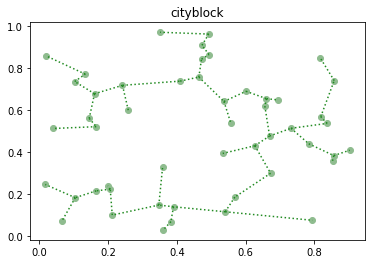

(cityblock) Execution Time:  0.001494480000474141


In [233]:
#Manhattan/City Block
test_mst("cityblock")

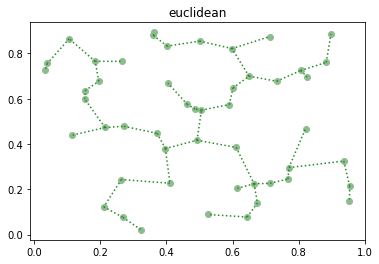

(euclidean) Execution Time:  0.0019118380005238578


In [234]:
test_mst('euclidean')

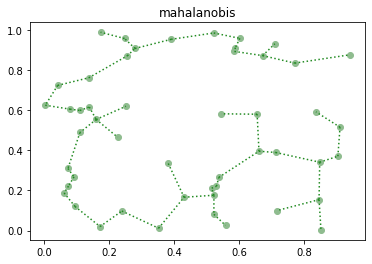

(mahalanobis) Execution Time:  0.012272066000150517


In [238]:
test_mst('mahalanobis')